<a id="Subcluster_B"></a>
## Sub-cluster B-cells

- [1. Load raw data](#loadB)
- [2. Subclustering 1 - remove doublets](#cluster_test)
- [3. Subclustering 2 - classify cell types](#cluster_B2)
- [4. Output results figures](#figuresB)

In [1]:
import os
adir = '../../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False
results_dir = '../../../../../results'

abase = os.path.join(adir, project_name)
abase

'../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


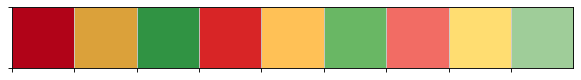

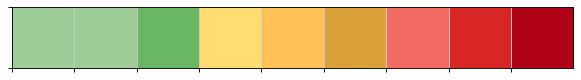

In [5]:
dpi_colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(dpi_colors)
sns.palplot(dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

dpi_colors2 = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
dpimap2 = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors2[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap2['0'] = palettable.tableau.TableauMedium_10.hex_colors[-1]

<a id="loadB"></a>
## Load raw data and previous clustering results

In [6]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterM.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)
adata_annot = read_adata(annot_file, gcs=gcs)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterM.h5ad
Only considering the two last: ['.SubclusterM', '.h5ad'].
Only considering the two last: ['.SubclusterM', '.h5ad'].


In [8]:
adata_annot

AnnData object with n_obs × n_vars = 61819 × 16853 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dis

In [ ]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['B', 'Plasmablast']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 4274 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


<a id="cluster_test"></a>
## Iterative subclustering 1 - removes doublets

In [16]:
genestoplot = ['MS4A1', 'CD3D', 'IGHM', 'ENSMMUG00000002764', 'ENSMMUG00000015202', 'MZB1', 'MKI67', 'HBB', 'frz_status', 'MAMU-DPB']

In [17]:
(adata_raw.shape[0]*.001)

15.518

In [18]:
30 / adata_raw.shape[0]

0.0019332388194354942

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)


... storing 'Subclustering' as categorical


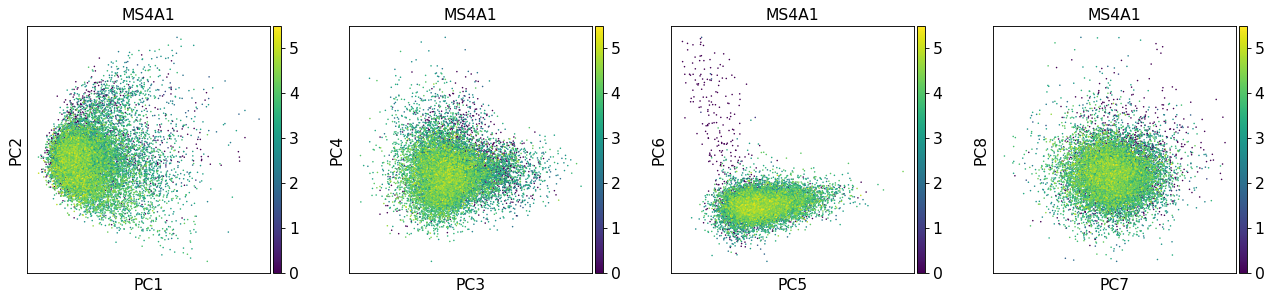

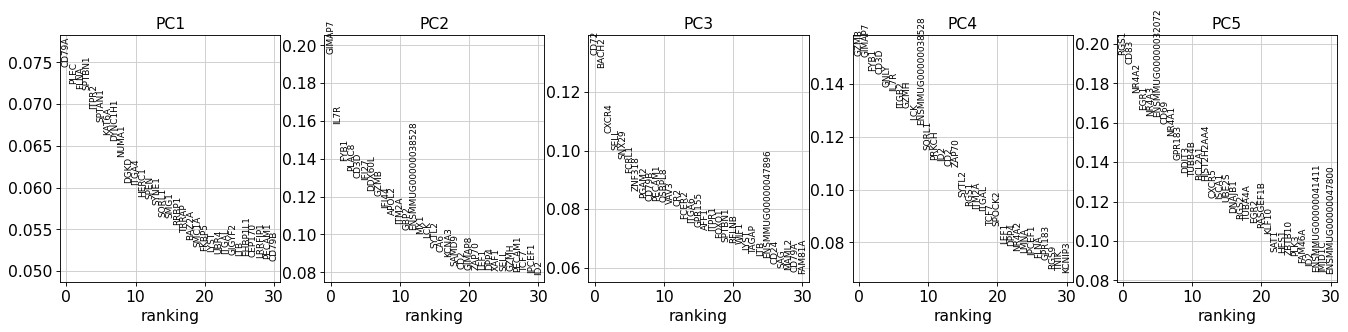

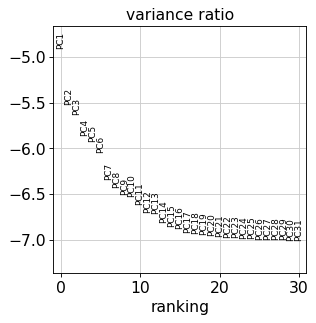

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:25)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


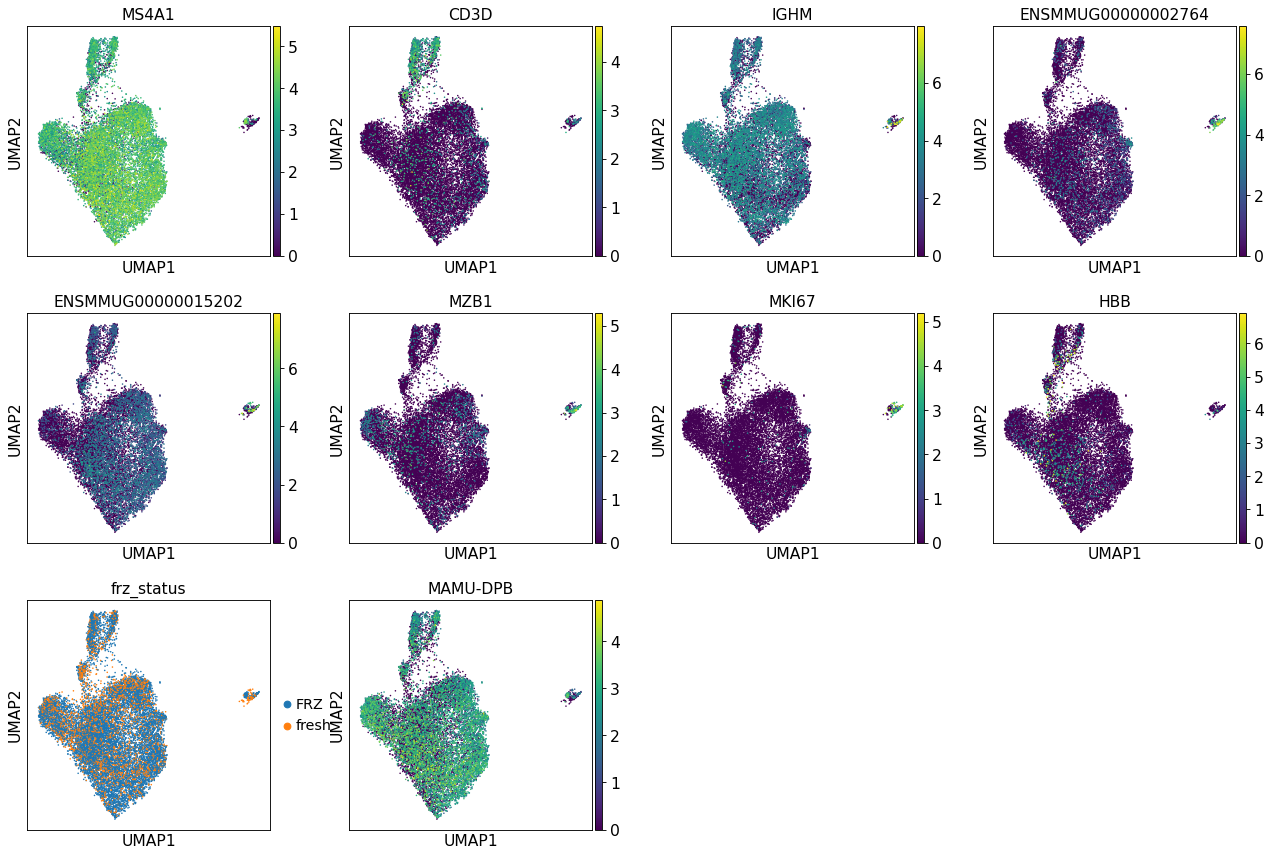

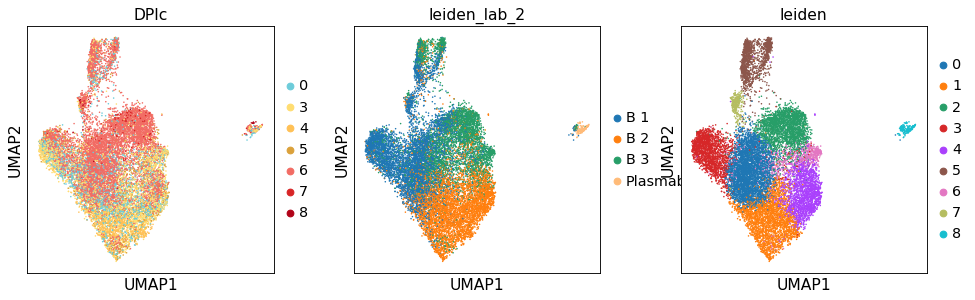

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


0                   1       2                   3  \
0               RPS4Y1              GPR183  DDX60L              RPS27A   
1               DDX60L               NR4A2     MX1                SELL   
2                 COX2               ZFP36   HERC5              NFKBIA   
3                RPS11                 UBC   DDX60               CD79B   
4                RPS14                RGS1     MX2              OSBPL8   
5   ENSMMUG00000014256               ISCA1   PLAC8               CXCR4   
6               MAMU-B                 FOS  SAMD9L  ENSMMUG00000003867   
7                RPS23                CD83  RNF213               BACH2   
8               RPL27A                RGS2  SMCHD1                CD72   
9                RPL11               MS4A1   IFI27               TXNIP   
10                RPS6                EIF5   ISG15                RPL8   
11               RPL13  ENSMMUG00000021766  EPSTI1                IGHM   
12  ENSMMUG00000003073               NR4A1  MAMU-B               RACK1   
13               RPS20               CCNL1   SP100             CSNK1G3   
14               RPS16               HSPA5    GBP2               RPL18   
15              RPL13A  ENSMMUG00000047461   STAT1               RPS4X   
16               ISG15              LAPTM5    NUB1              RPL10A   
17               RPL17            MAMU-DPA   IFI16              RIPOR2   
18                RPS7             OSBPL11    AIM2                CD69   
19               RACK1               CXCR5    XAF1              PECAM1   

                     4        5                   6                   7  \
0                ITGB2   GIMAP7           C10orf128              S100A9   
1              S100A10     CD3D                AIM2              S100A8   
2                ITGAX     IL7R                SELL  ENSMMUG00000028701   
3            MAMU-DQA1     FYB1               RUFY3               PLAC8   
4               LAPTM5      ID2                CD52                 LYZ   
5                SYNE1  ZFP36L2                SSPN              GIMAP7   
6               GPR183     TPT1               ITGA4                MNDA   
7               LGALS1     GZMB                ETS1                COX2   
8             MAMU-DRA      LCK               ITGB1               IFI27   
9                AHNAK     GMFG               EEF1G                VCAN   
10                LCP1    KCNA3                CD53            SERPINB1   
11                LRMP    TXNIP                FLI1               ISG15   
12              TSPAN3   GIMAP6              RIPOR2                 MX1   
13               ANXA2    APOL2  ENSMMUG00000003867  ENSMMUG00000014402   
14                GRB2     ETS1             FAM107B                FYB1   
15               MEF2C  RARRES3               BASP1                PPBP   
16             OSBPL11   PECAM1               RPS4X                SOD2   
17              PLXNC1    ZAP70                LAX1                GBP2   
18  ENSMMUG00000015202     CD69                 LTB              RNF213   
19               PTPRC     GNLY               EVI2B                GZMB   

                     8  
0   ENSMMUG00000038560  
1              HSP90B1  
2                PDIA4  
3   ENSMMUG00000002764  
4                 MZB1  
5                 IRF4  
6                 SUB1  
7                 PPIB  
8                REXO2  
9                PDIA6  
10                 VIM  
11                MANF  
12               MKI67  
13               RRBP1  
14               HDLBP  
15  ENSMMUG00000006971  
16  ENSMMUG00000005314  
17               ITGA4  
18                P4HB  
19                AQP3

In [19]:
adata_1 = subcluster_iteration(adata_raw, min_cells=10, nhvgs=nhvgs, npcs=17,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.,
                        umap_genestoplot=genestoplot, pc_genestoplot=['MS4A1'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'], harmony=True,
                        harmony_theta=.5, scale=True)

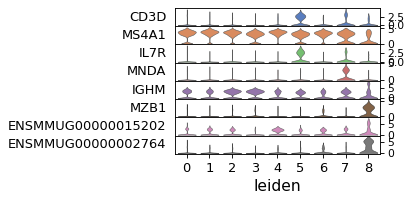

In [20]:
sc.pl.stacked_violin(adata_1, var_names=['CD3D', 'MS4A1', 'IL7R', 'MNDA', 'IGHM', 'MZB1', 'ENSMMUG00000015202', 'ENSMMUG00000002764'], groupby='leiden', swap_axes=True)

In [21]:
doublet_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(['5', '7'])]
adata_annot.obs.loc[doublet_ind, 'Doublet'] = True

adata_annot.obs.loc[:, 'Subclustering'] = adata_annot.obs.loc[:, 'Subclustering'].astype(str)
adata_annot.obs.loc[:, 'SubclusteringGroup'] = adata_annot.obs.loc[:, 'SubclusteringGroup'].astype(str)

plasmablast_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(['8'])]
adata_annot.obs.loc[plasmablast_ind, 'Subclustering'] = 'Plasmablast 1'
adata_annot.obs.loc[plasmablast_ind, 'SubclusteringGroup'] = 'Plasmablast'

<a id="cluster_B2"></a>
## Iterative subclustering 2 - classify cell types

In [22]:
genestoplot2 = ['MS4A1', 'SELL', 'ITGB2', 'IGKC', 'CD79B', 'frz_status', 'MAMU-DPB']

filtered out 546 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


... storing 'Subclustering' as categorical


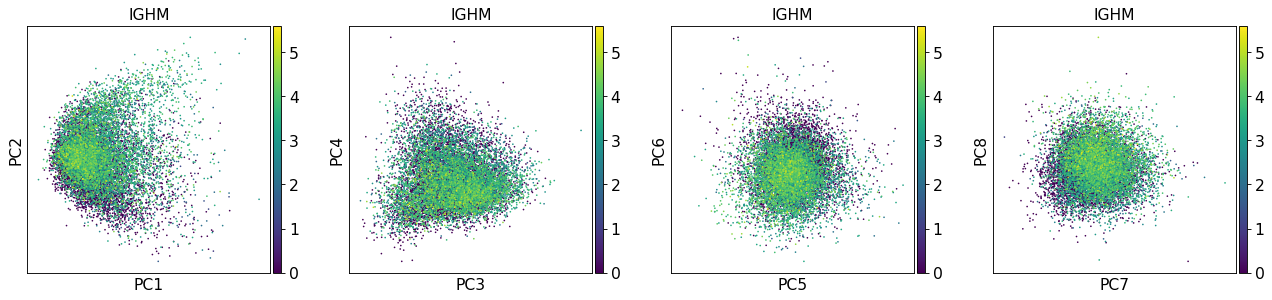

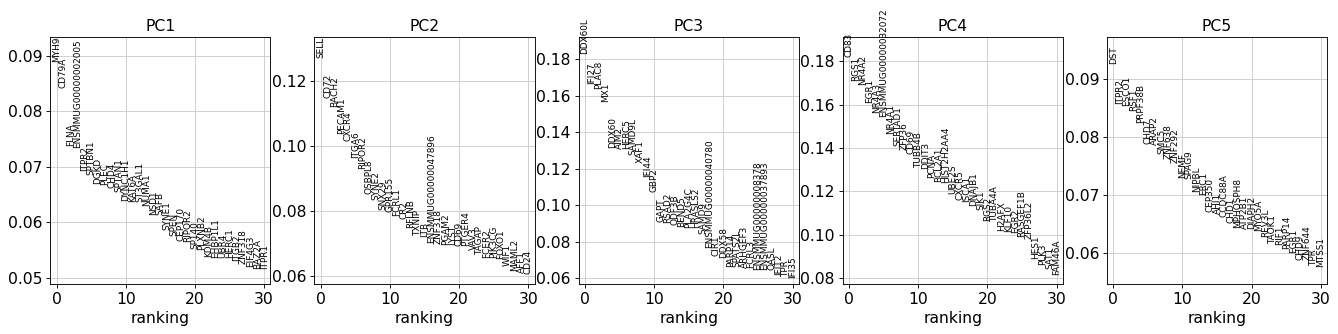

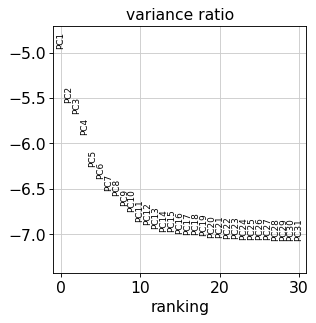

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:31)


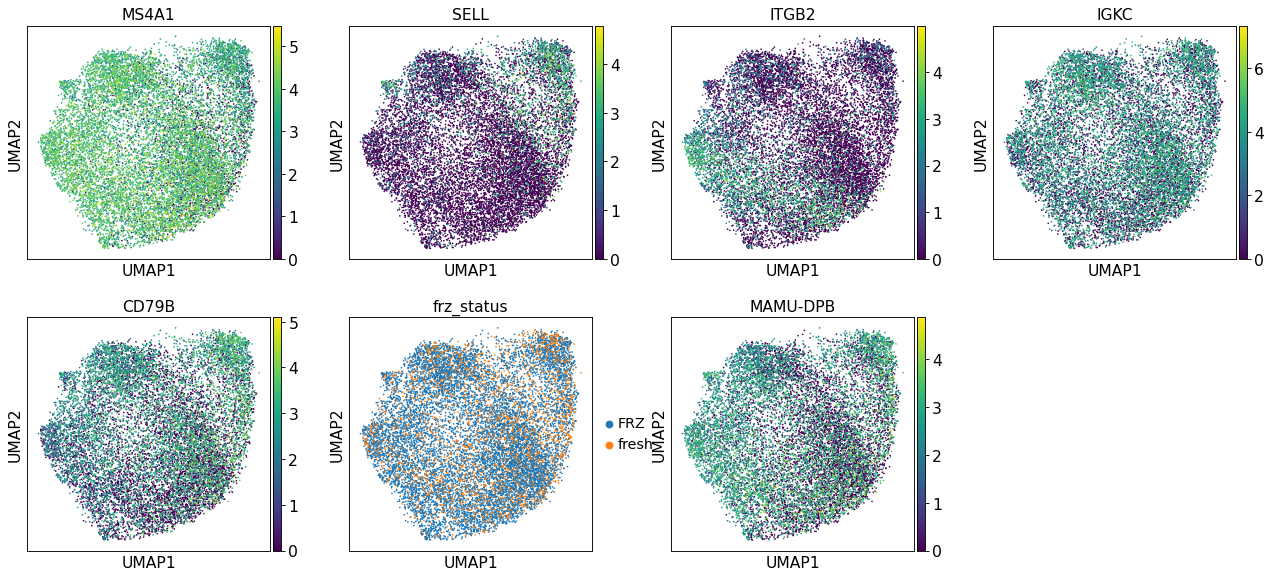

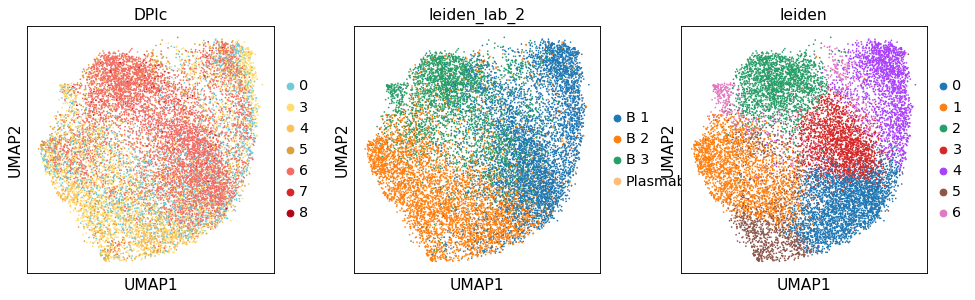

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


0          1       2                   3  \
0   ENSMMUG00000014256      ITGB2  DDX60L              DDX60L   
1                RPL17     GPR183     MX1               PLAC8   
2              S100A10    S100A10   PLAC8              RPS4Y1   
3                  UBC     LAPTM5   DDX60              MAMU-B   
4                 RPS6      ITGAX   IFI27               ISG15   
5               GPR183    OSBPL11  SAMD9L                COX2   
6                RPS11     LGALS1   HERC5                 MX1   
7               RPL13A      SYNE1     MX2               IFI27   
8                RPS14  MAMU-DQA1   ISG15               DDX60   
9                 GNAS       LCP1  RNF213               SP100   
10                 HBB      ANXA2  SMCHD1              SMCHD1   
11                RPS7   MAMU-DPA    GBP2                 MX2   
12               RPS23     S100A4  EPSTI1                IGHM   
13                RPS5       LRMP   STAT1                AIM2   
14              RPL27A     TSPAN3  PARP14               SYNE2   
15               RPL35    TSPAN33  MAMU-B               HERC5   
16                 UBB       GRB2   IFIH1                XAF1   
17               RPL23      IFI30    AIM2                SMC6   
18  ENSMMUG00000003073   MAMU-DRA    XAF1  ENSMMUG00000014256   
19               RPL11     FCGR2A    OAS2                GBP2   

                     4                   5          6  
0               RPS27A                 FOS  C10orf128  
1                 SELL                 UBC       CD52  
2               NFKBIA                EGR1       SELL  
3                TXNIP               CCNL1       ETS1  
4               OSBPL8               NR4A2     RIPOR2  
5                CXCR4                CD83      ITGA4  
6                CD79B                EIF5        VIM  
7                 CD72               ZFP36      ITGB1  
8                BACH2             GADD45B      RPS4X  
9   ENSMMUG00000003867               NR4A1      RUFY3  
10               RACK1              GPR183      EEF1G  
11              RIPOR2               HSPA5       BIN2  
12              PECAM1              NFKBIA       ADD3  
13                RPL8  ENSMMUG00000021766       SSPN  
14                CD69                SFPQ     EEF1A1  
15               RPS4X               RBM39      BASP1  
16              RPL10A                RGS1       AIM2  
17               RPL18            HSP90AB1      EVI2B  
18                UTRN                KLF6        LTB  
19                IGHM  ENSMMUG00000032072      RPLP0

In [40]:
keep = adata_1.obs.index[~adata_1.obs['leiden'].isin(['5', '7', '8'])]
adata_2 = subcluster_iteration(adata_raw[keep,:], min_cells=10, nhvgs=nhvgs, npcs=14,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.,
                        umap_genestoplot=genestoplot2, pc_genestoplot=['IGHM'],
                        other_plot=['DPIc', 'leiden_lab_2', 'leiden'], harmony=True,
                        harmony_theta=.5, scale=True)


In [41]:
adata_2.obs['leiden'].value_counts()

0    2990
1    2467
2    2222
3    2025
4    1937
5    1223
6     641
Name: leiden, dtype: int64

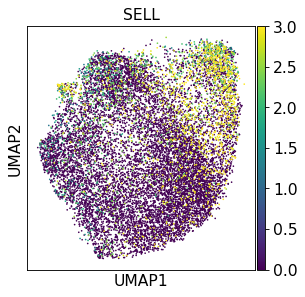

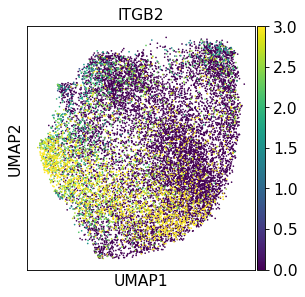

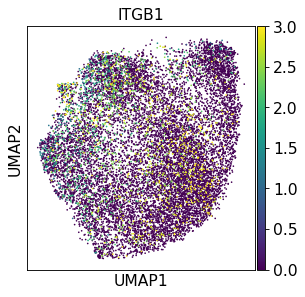

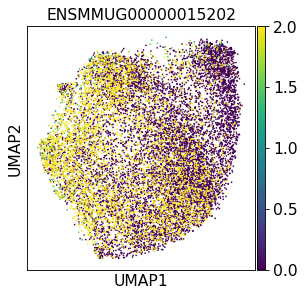

In [42]:
sc.pl.umap(adata_2, color=['SELL'], vmax=3)
sc.pl.umap(adata_2, color=['ITGB2'], vmax=3)
sc.pl.umap(adata_2, color=['ITGB1'], vmax=3)
sc.pl.umap(adata_2, color=['ENSMMUG00000015202'], vmax=2)

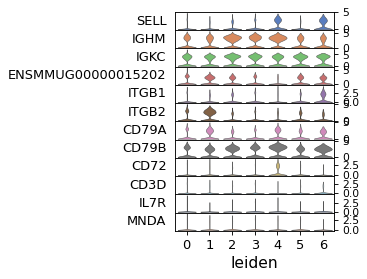

In [43]:
_ = sc.pl.stacked_violin(adata_2, var_names=['SELL',  'IGHM', 'IGKC', 'ENSMMUG00000015202',  'ITGB1', 'ITGB2', 'CD79A', 'CD79B', 'CD72', 'CD3D','IL7R', 'MNDA'], groupby='leiden', swap_axes=True)

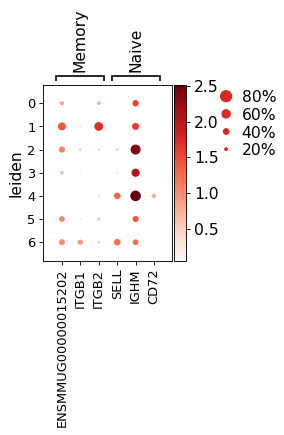

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[2.0999999999999996, 0, 0.2, 0.5, 0.25])

In [44]:
sc.pl.dotplot(adata_2, var_names={'Memory':['ENSMMUG00000015202',  'ITGB1', 'ITGB2'],
                                  'Naive':['SELL',  'IGHM', 'CD72']},
              groupby='leiden')

In [45]:
## Harmony + baseline PCs
labmap = {'0':'B_Memory 1',
          '1':'B_Memory 2',
          '2':'B_Memory 3',
          '3':'B_Memory 4',
          '4':'B_Naive 1',
          '5':'B_Memory 4',
          '6':'B_Memory_SELL+ 1'}

In [46]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


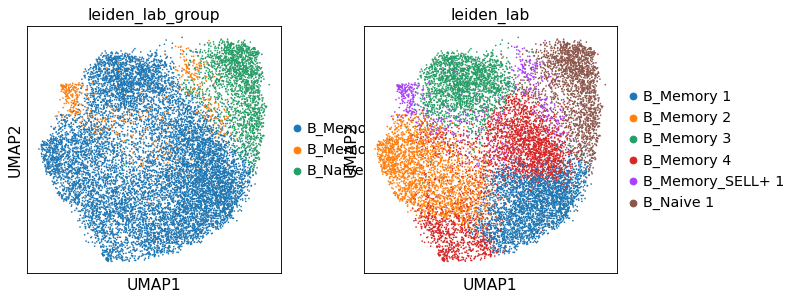

In [47]:
sc.pl.umap(adata_2, color=['leiden_lab_group', 'leiden_lab'])

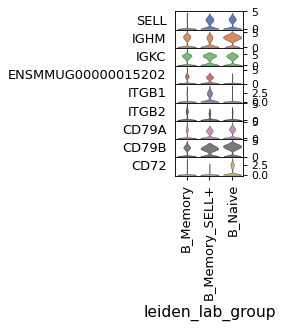

In [48]:
_ = sc.pl.stacked_violin(adata_2, var_names=['SELL',  'IGHM', 'IGKC', 'ENSMMUG00000015202',  'ITGB1', 'ITGB2', 'CD79A', 'CD79B', 'CD72'], groupby='leiden_lab_group', swap_axes=True)

In [49]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']
adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab']

In [50]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterMB.h5ad


In [51]:
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterMB', '.h5ad'].
Only considering the two last: ['.SubclusterMB', '.h5ad'].


... storing 'SubclusteringGroup' as categorical
... storing 'Subclustering' as categorical


In [52]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyB.h5ad


In [53]:
save_adata(adata_2, results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyB', '.h5ad'].
Only considering the two last: ['.OnlyB', '.h5ad'].


In [54]:
pd.crosstab([adata_annot.obs['leiden_lab_group_2'], adata_annot.obs['Doublet']], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup          B_Memory  B_Memory_SELL+  B_Naive  Mono  Neut  \
leiden_lab_group_2 Doublet                                                  
B                  False       10908             640     1936     0     0   
                   True            0               0        0     0     0   
Mono/DC            False           0               0        0  6958    47   
                   True            0               0        0     0     0   
NK                 False           0               0        0     0     0   
Neut               False           0               0        0    12  5756   
                   True            0               0        0     0     0   
Plasmablast        False          19               1        1     0     0   
                   True            0               0        0     0     0   
Platelet           False           0               0        0     6     2   
                   True            0               0        0     0     0   
Tc                 False           0               0        0     0     0   
Th                 False           0               0        0     0     0   

SubclusteringGroup          Plasmablast  cDC    nan  pDC  
leiden_lab_group_2 Doublet                                
B                  False             90    0      0    0  
                   True               0    0   1704    0  
Mono/DC            False              0  345      0  330  
                   True               0    0    840    0  
NK                 False              0    0   1191    0  
Neut               False              0    0      0    0  
                   True               0    0    206    0  
Plasmablast        False            176    0      0    0  
                   True               0    0     43    0  
Platelet           False              0    0      0    2  
                   True               0    0    298    0  
Tc                 False              0    0  11002    0  
Th                 False              0    0  19306    0

In [55]:
pd.crosstab(adata_annot.obs['Subclustering'], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup  B_Memory  B_Memory_SELL+  B_Naive  Mono  Neut  \
Subclustering                                                       
B_Memory 1              2990               0        0     0     0   
B_Memory 2              2467               0        0     0     0   
B_Memory 3              2222               0        0     0     0   
B_Memory 4              3248               0        0     0     0   
B_Memory_SELL+ 1           0             641        0     0     0   
B_Naive 1                  0               0     1937     0     0   
Mono 1                     0               0        0  1477     0   
Mono 2                     0               0        0  1172     0   
Mono 3                     0               0        0  1125     0   
Mono 4                     0               0        0  1076     0   
Mono 5                     0               0        0  1065     0   
Mono 6                     0               0        0   463     0   
Mono 7                     0               0        0   436     0   
Mono 8                     0               0        0   162     0   
Neut 1                     0               0        0     0  1454   
Neut 2                     0               0        0     0  1324   
Neut 3                     0               0        0     0  1202   
Neut 4                     0               0        0     0   972   
Neut 5                     0               0        0     0   550   
Neut 6                     0               0        0     0   303   
Plasmablast 1              0               0        0     0     0   
cDC 1                      0               0        0     0     0   
nan                        0               0        0     0     0   
pDC 1                      0               0        0     0     0   

SubclusteringGroup  Plasmablast  cDC    nan  pDC  
Subclustering                                     
B_Memory 1                    0    0      0    0  
B_Memory 2                    0    0      0    0  
B_Memory 3                    0    0      0    0  
B_Memory 4                    0    0      0    0  
B_Memory_SELL+ 1              0    0      0    0  
B_Naive 1                     0    0      0    0  
Mono 1                        0    0      0    0  
Mono 2                        0    0      0    0  
Mono 3                        0    0      0    0  
Mono 4                        0    0      0    0  
Mono 5                        0    0      0    0  
Mono 6                        0    0      0    0  
Mono 7                        0    0      0    0  
Mono 8                        0    0      0    0  
Neut 1                        0    0      0    0  
Neut 2                        0    0      0    0  
Neut 3                        0    0      0    0  
Neut 4                        0    0      0    0  
Neut 5                        0    0      0    0  
Neut 6                        0    0      0    0  
Plasmablast 1               266    0      0    0  
cDC 1                         0  345      0    0  
nan                           0    0  34590    0  
pDC 1                         0    0      0  332

<a id="figuresB"></a>
## Output figures

In [11]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)
adata_2 = read_adata(results_file_sub, gcs=gcs)

annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterM.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)
adata_annot = read_adata(annot_file, gcs=gcs)

adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group_2'].isin(['B', 'Plasmablast']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyB.h5ad
Only considering the two last: ['.OnlyB', '.h5ad'].
Only considering the two last: ['.OnlyB', '.h5ad'].
../../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.SubclusterM.h5ad
Only considering the two last: ['.SubclusterM', '.h5ad'].
Only considering the two last: ['.SubclusterM', '.h5ad'].
filtered out 4274 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [12]:
expression_full = pd.DataFrame(adata_raw[adata_2.obs.index,:].X.todense(), index=adata_2.obs.index, columns=adata_raw.var.index)
expression_full.rename(columns={'ENSMMUG00000015202':'IGHG'}, inplace=True)


genes_to_plot = ['SELL', 'CD72', 'IGHM', 'IGHG', 'ITGB2']
celltype_order = ['B Naive', 'B Memory', 'B Memory SELL+']
adata_2.obs['Grouped_Clustering'] = pd.Categorical(adata_2.obs['leiden_lab_group'].apply(lambda x: x.replace('_', ' ')).values, categories=celltype_order)

expression = expression_full.loc[:, genes_to_plot]
obs = adata_2.obs.copy()
obs['UMAP_1'] = adata_2.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_2.obsm['X_umap'][:,1]

In [13]:
ctcolors = ['#124E78', '#F2BB05', '#D74E09']
ctmap = {'B Memory':ctcolors[1], 'B Naive':ctcolors[0], 'B Memory SELL+':ctcolors[2]}
obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)

In [14]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

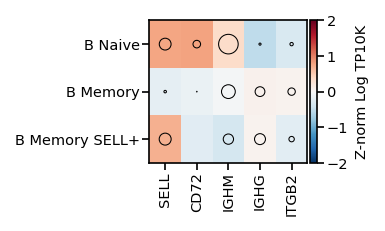

In [46]:
percent_positive = expression.groupby(obs['Grouped_Clustering']).agg(lambda x: (x>0).mean())

expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(adata_2.obs['Grouped_Clustering']).mean()

width=2.5
heatmap_width=1.5
legend_width=.6
left_space=.4

heatmap_height = .95
bottom_space = .42
top_space = .13
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height
sizelegendfontsize = 7

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

alldotsize = percent_positive.copy()
alldotsize = alldotsize - alldotsize.min().min()
alldotsize = alldotsize / alldotsize.max().max()
alldotsize = (alldotsize * 9.4) ** 2

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)

for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)

#heatmap_ax.set_title('B - Seq-Well', pad=0)
        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 9.4) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .35

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.1, .65, 5)
size_legend_ax.text(.6, .5, 'Z-norm Log TP10K', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)

'''
size_legend_ax.scatter(leg_x, leg_y, s=leg_dot_size, edgecolor='k',  linewidth=.5, c='.8')

for i in range(5):
    size_legend_ax.text(leg_x[i]+text_offset, leg_y[i], ('%d' % (100*vals[i])) + '%', fontsize=sizelegendfontsize, va='center')
size_legend_ax.text(.6, 1.05, '% Cells\nwith gene\ndetected', ha='center', va='top', fontsize=sizelegendfontsize)
''' 
    
figure_file = os.path.join(results_dir, "Subcluster.B.Seqwell.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [43]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

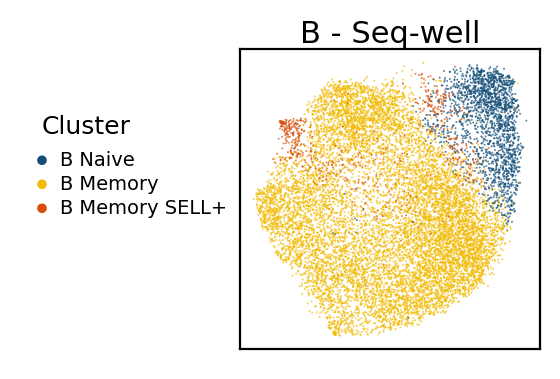

In [45]:
leg_width=1.1
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs['UMAP_1'], obs['UMAP_2'], c=obs['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

marker_x=.1
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.63, .47, num=N)):
  ct = celltype_order[i]
  legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.1, .72, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'B - Seq-well', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.B.Seqwell.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)